# **Chatgpt Review Sentiment Analysis** 🤖



This project aims to perform **sentiment analysis** on user reviews of ChatGPT to understand the overall user sentiment and extract meaningful insights. The dataset consists of four columns:

* Review id: Unique identifier for each review
* Review: User-generated review text
* Ratings: Numerical rating (e.g., 1-5)
* Review date: Date when the review was posted

Data Source: https://www.kaggle.com/datasets/anandshaw2001/chatgpt-users-reviews/data

In [3]:
# import packages
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### **1️⃣ Data Preparation & Cleaning**

- Load and inspect the dataset.
- Address missing values and duplicates.
- Clean the text data (remove special characters, stopwords, etc).
- Explore data by descriptive statistics.




In [5]:
# Load dataset
df = pd.read_csv('ChatGPT_Reviews.csv')

In [6]:
# Inspect the dataset
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,8/23/2024 19:30
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,8/23/2024 19:28
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,8/23/2024 19:22
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,8/23/2024 19:20
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,8/23/2024 19:20


In [7]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64


In [8]:
print("\nDuplicate entries:", df.duplicated().sum())


Duplicate entries: 2511


In [9]:
# Drop missing values
df = df.dropna()
print(df.isnull().sum())

Review Id      0
Review         0
Ratings        0
Review Date    0
dtype: int64


In [10]:
# Drop duplicates
df = df.drop_duplicates()
print("\nDuplicate entries:", df.duplicated().sum())


Duplicate entries: 0


In [11]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return " ".join(words)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"U0001F600-U0001F64F" # Emoticons
                           u"U0001F300-U0001F5FF" # Symbols & pictographs
                           u"U0001F680-U0001F6FF" # Transport & map symbols
                           u"U0001F1E0-U0001F1FF" # Flags (iOS)
                           u"U00002702-U000027B0" # Miscellaneous symbols
                           u"U000024C2-U0001F251" # Enclosed characters
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

Citation: *Text Cleaning Methods in NLP* https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/

In [12]:
# Apply text cleaning to the "Review" column
df["Cleaned_Review"] = df["Review"].apply(clean_text).apply(remove_emoji)
df["Cleaned_Review"]

,Cleaned_Review
0,good
1,good
2,nice app
3,nice ig
4,great app bot accurate anything gives tips gam...
...,...
196722,update
196723,grear
196724,funtastic app
196725,hi


In [13]:
print("\nBasic statistics for Ratings:")
df['Ratings'].describe()


Basic statistics for Ratings:


,Ratings
count,194210.000000
mean,4.502678
std,1.084163
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [14]:
# Save cleaned dataset
df.to_csv("Cleaned_ChatGPT_Reviews.csv", index=False)

### 2️⃣ **Exploratory Data Analysis  & Visualization**
* Distributions of features:
    * Ratings
    * Review lengths
* Word Clouds of the Reviews
    * Display a word cloud of the reviews
    * The most frequent words used in reviews for each rating category
* Temporal Trends
    * Ratings over time
    * Number of reviews over time
* Sentiment Distribution
    * Transform ratings into sentiment categories
    * Distribution of Sentiment
    * Sentiment Distribution Over Time
* EDA Summary

In [15]:
# Convert Review Date to datetime format, Ratings to numeric format
df["Review Date"] = pd.to_datetime(df["Review Date"], errors='coerce')
df['Ratings'] = pd.to_numeric(df['Ratings'], errors='coerce')

# Add a column for review length (word count)
df["Review Length"] = df["Cleaned_Review"].apply(lambda x: len(str(x).split()))
df

,Review Id,Review,Ratings,Review Date,Cleaned_Review,Review Length
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:00,good,1
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:00,good,1
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:00,nice app,2
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:00,nice ig,2
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:00,great app bot accurate anything gives tips gam...,33
...,...,...,...,...,...,...
196722,462686ff-e500-413c-a6b4-2badc2e3b21d,Update 2023,5,2023-07-27 16:26:00,update,1
196723,f10e0d48-ecb6-42db-b103-46c0046f9be9,its grear,5,2023-09-23 16:25:00,grear,1
196724,df909a49-90b5-4dac-9b89-c4bd5a7c2f75,Funtastic App,5,2023-11-08 13:57:00,funtastic app,2
196725,abe43878-973f-4e96-a765-c4af5c7f7b20,hi all,5,2023-07-25 15:32:00,hi,1


<ipython-input-16-9fda2fcc2ef4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Ratings"], palette="Blues")


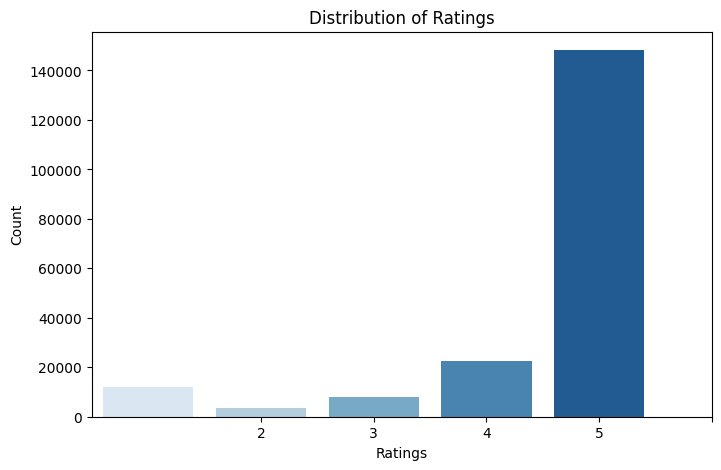

In [16]:
# --- Distribution of Ratings ---
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Ratings"], palette="Blues")
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.xticks(range(1, 6))
plt.show()

> * The majority of the reviews are 5-star ratings, indicating a generally positive user experience.
> * There are significantly fewer 1-star and 2-star reviews, suggesting that extreme dissatisfaction is relatively rare.
> * **Insight**: The dataset is highly skewed towards positive reviews, which may impact sentiment analysis and introduce potential bias.

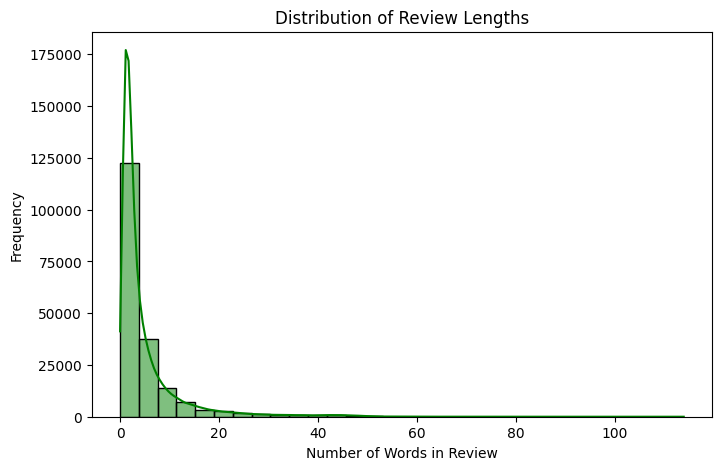

In [17]:
# --- Distribution of Review Lengths ---
plt.figure(figsize=(8, 5))
sns.histplot(df["Review Length"], bins=30, kde=True, color="green")
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words in Review")
plt.ylabel("Frequency")
plt.show()

> * Most reviews are short, with a high frequency of very brief comments.
> * There is a long tail distribution, meaning some reviews contain significantly more words.
> * **Insight**: The majority of users provide concise feedback, which may limit the depth of textual analysis.

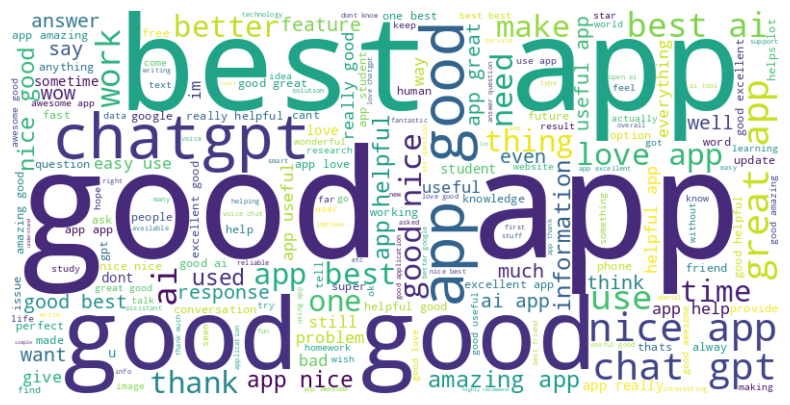

In [18]:
# --- Display a word cloud of the reviews ---
def generate_word_cloud(df):
    text = " ".join(review for review in df['Cleaned_Review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(df)

> * Common words include "good," "app," "best," "chatgpt," and "ai," indicating that users frequently mention the application's quality and AI capabilities.
> * **Insight**: Positive and neutral descriptors dominate, reflecting the high proportion of 5-star reviews.

In [19]:
# --- The most frequent words used in reviews for each rating category ---
def get_top_words(reviews, n=10):
    stop_words = set(stopwords.words('english'))
    words = " ".join(reviews).lower().translate(str.maketrans('', '', string.punctuation)).split()
    words = [word for word in words if word not in stop_words]
    return Counter(words).most_common(n)

for rating in sorted(df['Ratings'].unique(), reverse=True):
    top_words = get_top_words(df[df["Ratings"] == rating]["Cleaned_Review"], n=10)
    print(f"Top words for rating {rating}: {top_words}")

Top words for rating 5: [('app', 37348), ('good', 28572), ('best', 16221), ('nice', 10796), ('helpful', 9437), ('great', 9372), ('ai', 9025), ('love', 7636), ('amazing', 7523), ('chatgpt', 7378)]
Top words for rating 4: [('good', 6320), ('app', 5758), ('nice', 1833), ('great', 1714), ('like', 1584), ('helpful', 1458), ('ai', 1379), ('best', 1289), ('chatgpt', 1232), ('really', 1136)]
Top words for rating 3: [('good', 2205), ('app', 1892), ('like', 555), ('nice', 547), ('chatgpt', 477), ('chat', 431), ('use', 426), ('ai', 416), ('great', 413), ('please', 389)]
Top words for rating 2: [('app', 871), ('good', 581), ('cant', 303), ('like', 279), ('chatgpt', 274), ('chat', 224), ('please', 216), ('time', 202), ('use', 202), ('doesnt', 198)]
Top words for rating 1: [('app', 3420), ('cant', 1310), ('good', 1096), ('use', 883), ('even', 843), ('doesnt', 815), ('dont', 723), ('time', 703), ('ai', 695), ('error', 690)]


> * 5-star reviews contain words like "app", "good", "best", "helpful", and "love" highlighting appreciation.
> * 1-star and 2-star reviews frequently contain "can't", "doesn't", "error", and "time" indicating common user frustrations.
> * **Insight**: The differentiation in word usage suggests distinct sentiment trends, which could help in classifying review sentiment.

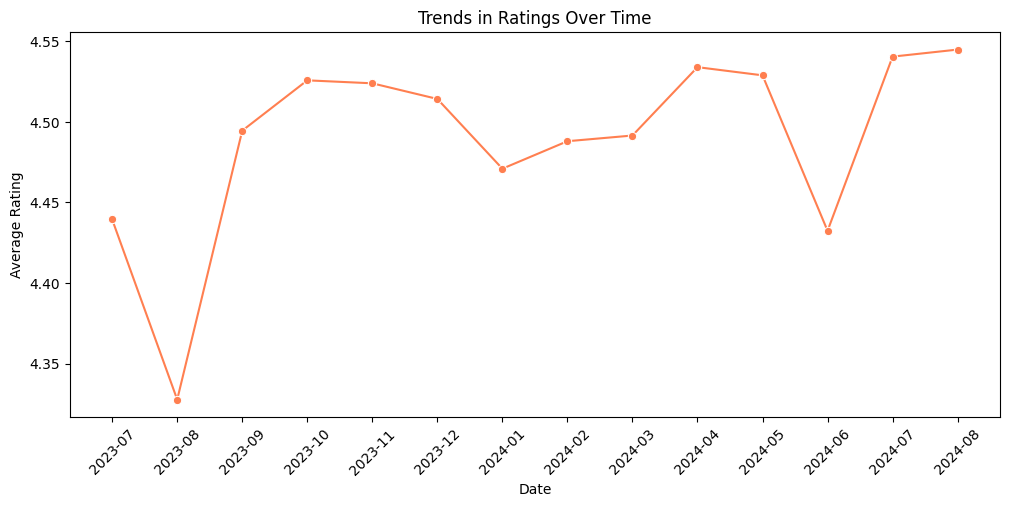

In [20]:
# --- Trends in Ratings Over Time ---
df_grouped = df.groupby(df["Review Date"].dt.to_period("M"))["Ratings"].mean().reset_index()
df_grouped["Review Date"] = df_grouped["Review Date"].astype(str)  # Convert period to string for plotting

plt.figure(figsize=(12, 5))
sns.lineplot(x="Review Date", y="Ratings", data=df_grouped, marker="o", color="coral")
plt.xticks(rotation=45)
plt.title("Trends in Ratings Over Time")
plt.xlabel("Date")
plt.ylabel("Average Rating")
plt.show()

> * The average rating fluctuates over time but remains relatively high, generally above 4.3 stars.
> * There are occasional dips in rating trends, which may correlate with specific product updates or external factors.
> * **Insight**: Monitoring these dips can help identify periods of user dissatisfaction and investigate potential causes.

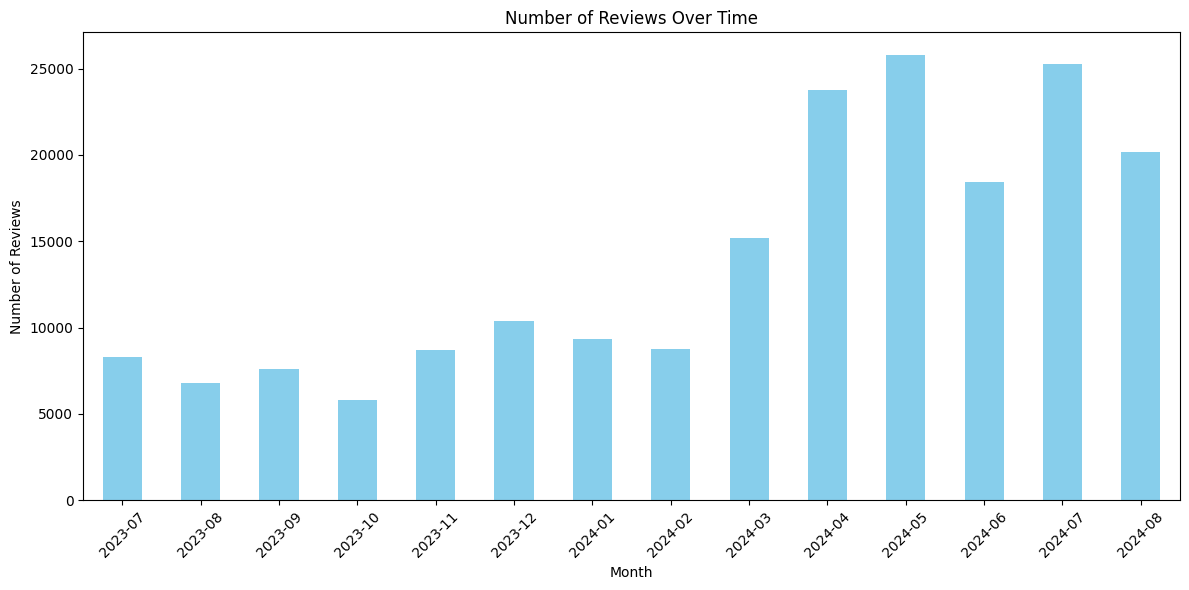

In [21]:
# --- Trends in Number of Reviews Over Time ---
review_counts = df.groupby(df['Review Date'].dt.to_period('M')).size()
review_counts.plot(kind='bar', color='skyblue', figsize=(12, 6))
plt.title("Number of Reviews Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> * There are spikes in review activity, indicating periods of high user engagement.
> * More recent months show an increase in review submissions.
> * **Insight**: Increased review frequency might align with marketing campaigns, feature updates, or wider adoption of the product.

In [22]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def classify_sentiment(review):
    sentiment_score = analyzer.polarity_scores(review)['compound']
    if sentiment_score >= 0.05:
        return 'positive'
    elif sentiment_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment classification to each review
df['Sentiment'] = df['Review'].apply(classify_sentiment)

# Preview the sentiment categorized data
df[['Review', 'Sentiment']].head()

,Review,Sentiment
0,good,positive
1,good,positive
2,nice app,positive
3,"nice, ig",positive
4,"this is a great app, the bot is so accurate to...",positive


<ipython-input-23-3aa727563a22>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sentiment"], palette="Blues")


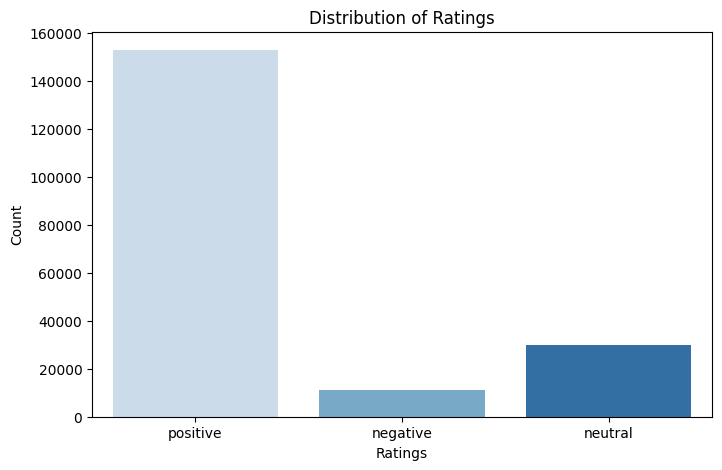

In [23]:
# --- Distribution of Sentiment ---
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Sentiment"], palette="Blues")
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.xticks(range(0, 3))
plt.show()

> * Sentiment categories are strongly skewed towards Positive due to the dominance of high ratings.
> * Negative and Neutral reviews represent a small proportion of the dataset.
> * **Insight**: The imbalance in sentiment categories suggests a need for stratified analysis or weighting adjustments when training machine learning models.

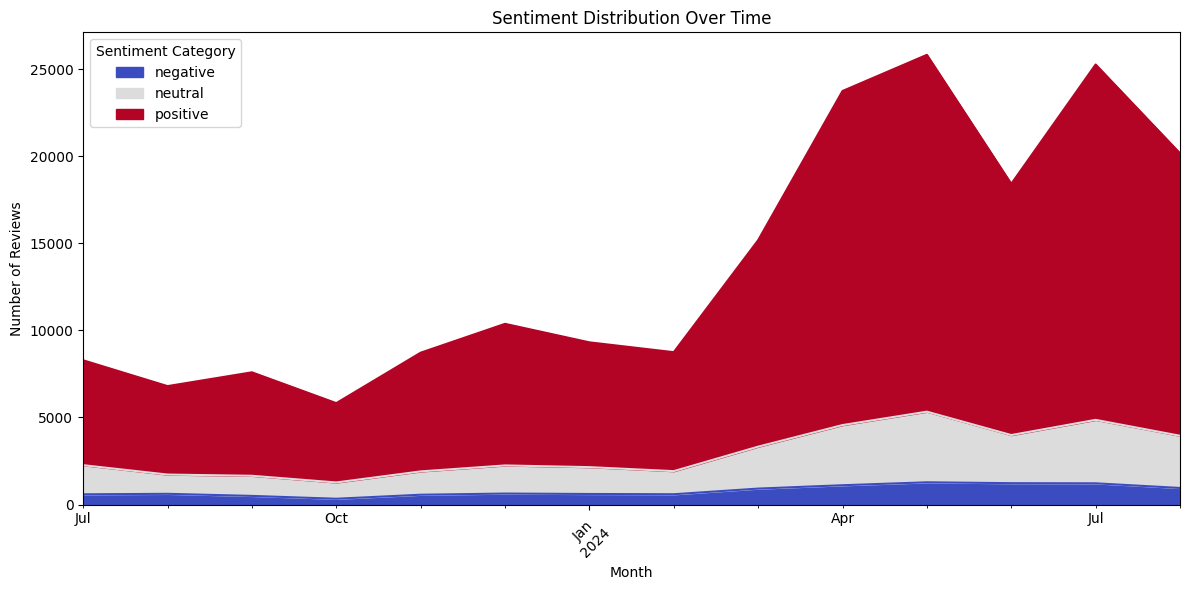

In [24]:
# --- Sentiment Distribution Over Time ---
sentiment_trend = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)
sentiment_trend.plot(kind='area', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title("Sentiment Distribution Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> * Positive sentiment has been consistently dominant and increses in recent months.
> * There is a slight increase in Neutral and Negative reviews in certain months.
> * **Insight**: Fluctuations in sentiment may correspond to product changes, policy shifts, or external factors affecting user experience.

### 📌 **EDA Summary**

1. **Distribution of Features**:
 - **Ratings**: The majority of ratings are 5 stars, indicating highly positive reviews. Lower ratings (1-4 stars) are significantly less frequent, suggesting a skewed rating distribution.
 - **Review Length**: Most reviews are short, with a peak at fewer than 10 words.
There are very few long reviews, and the frequency declines as the review length increases.

2. **Word Cloud Analysis**:

   Frequently used words include "good," "app," "best," "nice," "great," "helpful," and "useful. "The word cloud suggests that users generally express positive sentiments about the app.

3. **Temporal Trends**:
 - **Ratings over time**: Ratings fluctuate over time but remain consistently high.
A noticeable dip in ratings occurred in August 2023, followed by a recovery.
 - **Number of Reviews Over Time**: The number of reviews has been increasing, with a significant rise in early 2024. More user engagement in recent months suggests growing interest in the app.

4. **Sentiment Distribution**:
 - **Distribution of categories**: Most reviews are classified as positive, with very few negative or neutral reviews. This aligns with the skewed 5-star rating distribution.
 - **Sentiment Trends Over Time**: Positive sentiment dominates, with a steady increase in reviews. Negative and neutral sentiments remain minimal but show slight variations over time.


**Potential Issues...😱?**
* **Strong Positive Skew** → Most reviews are 5-star, making sentiment models biased toward positive predictions.
* **Short Review Bias** → Many reviews are very brief, making it hard to infer sentiment using NLP models.
* **Similar Word Usage Across Ratings** → Positive and negative reviews share common words (e.g., "app," "AI"), making classification harder.

Given the findings from EDA, we need to modify our approach to ensure accurate and meaningful sentiment analysis.

### 3️⃣ **Model Training for Sentiment Analysis**

* Transform the data for model training
 - Label encoding
 - TF-IDF Conversion
* Address imbalanced dataset (Issues from the previous part)
 - Oversample the Negative and Neutral Classes
 - Weighted classification
* Select and Train Sentiment Models
* Evaluate Model Performance
  

In [57]:
# Encode sentiments into numerical values
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

In [26]:
# Convert text data into TF-IDF features (using sparse matrix)
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust `max_features` as needed
X = tfidf.fit_transform(df['Review'])  # Keeps the sparse matrix

In [34]:
# Separate positive, neutral, and negative samples
df_negative = df[df['Sentiment'] == 'negative']
df_positive = df[df['Sentiment'] == 'positive']
df_neutral = df[df['Sentiment'] == 'neutral']

# Determine target sample size (same as the majority class, positive)
target_size = len(df_positive)

# Oversample the negative and neutral classes
df_negative_upsampled = resample(df_negative, replace=True, n_samples=target_size, random_state=42)
df_neutral_upsampled = resample(df_neutral, replace=True, n_samples=target_size, random_state=42)

# Combine the upsampled negative & neutral class with the positive class
df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# Print the new class distribution
print(df_balanced['Sentiment'].value_counts())

Sentiment
positive    153037
neutral     153037
negative    153037
Name: count, dtype: int64


In [35]:
# Prepare data for model training
X_balanced = tfidf.fit_transform(df_balanced['Review'])  # Use sparse matrix directly
y_balanced = df_balanced['sentiment_encoded']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [36]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

**Model Selection...🤔?**
1. **Logistic Regression**: Used because it is a strong linear classifier that works well with high-dimensional text data and can handle imbalanced datasets effectively by incorporating class weights.

2. **Multinomial Naive Baye**: Chosen because it is optimized for text classification, particularly with TF-IDF features, and assumes words contribute independently to sentiment, making it fast and effective for large datasets.

### Model 1: Logistic Regression

In [37]:
# Train a Logistic Regression model with class weights
model = LogisticRegression(class_weight=class_weights_dict, max_iter=1000)
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Print classification report
report_dict = classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.iloc[:3]

,precision,recall,f1-score,support
negative,0.928821,0.921843,0.925319,30618.0
neutral,0.914740,0.960390,0.937009,30699.0
positive,0.961033,0.920016,0.940077,30506.0


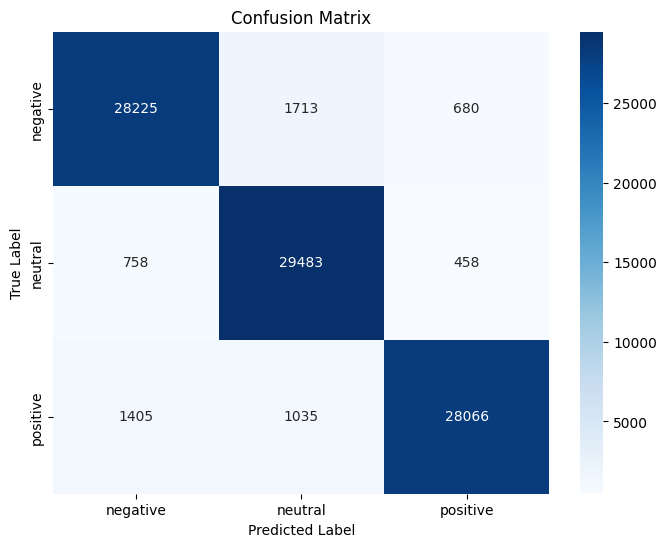

In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

ROC-AUC Score: 0.98


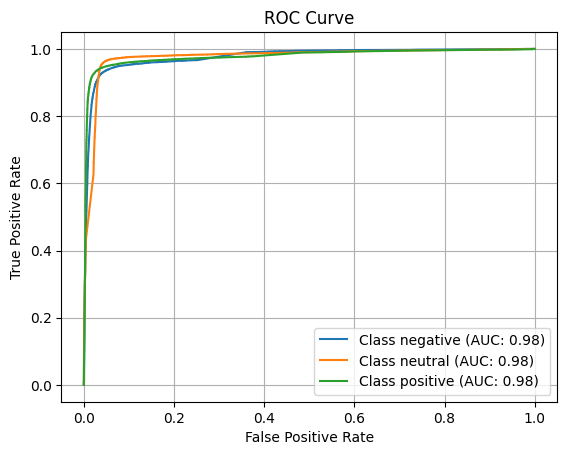

In [39]:
# Calculate probabilities for ROC-AUC
y_prob = model.predict_proba(X_val)

# ROC-AUC Score (one-vs-rest strategy for multiclass)
roc_auc = roc_auc_score(y_val, y_prob, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve for each class
for i, class_label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_val == i, y_prob[:, i])  # One-vs-rest
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC: {roc_auc_score(y_val == i, y_prob[:, i]):.2f})")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Summary**

📊 Classification Report: The model achieves high accuracy across all sentiment classes, with strong precision, recall, and F1-scores.

🔹 Confusion Matrix Analysis: Most predictions are correctly classified, with the best classification for the positive class.

📈 ROC-AUC Score (0.98): A high AUC score (0.98) across all classes, confirming the model’s strong ability to distinguish between negative, neutral, and positive sentiments.

### Model 2: Multinomial Naive Baye

In [40]:
# Train a Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_val)
y_pred_prob = nb_model.predict_proba(X_val)

# Print classification report
report_dict = classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.iloc[:3]

,precision,recall,f1-score,support
negative,0.761582,0.881050,0.816972,30618.0
neutral,0.903548,0.562396,0.693276,30699.0
positive,0.716952,0.876483,0.788732,30506.0


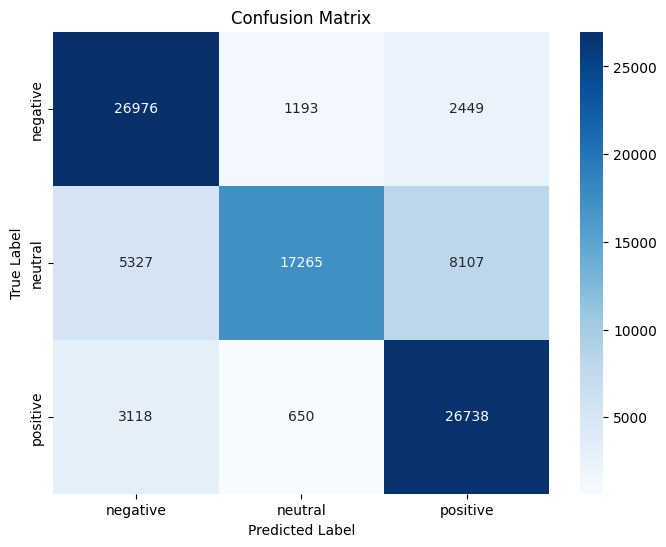

In [41]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

ROC-AUC Score: 0.95


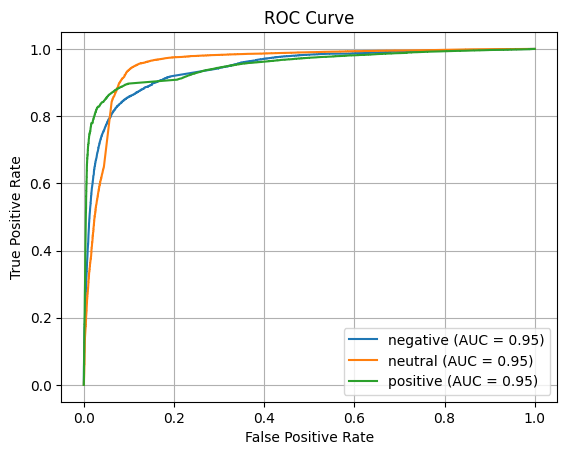

In [42]:
# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curves for each class
fpr = {}
tpr = {}
thresholds = {}

for i, class_label in enumerate(label_encoder.classes_):
    fpr[class_label], tpr[class_label], thresholds[class_label] = roc_curve(
        (y_val == i).astype(int), y_pred_prob[:, i]
    )
    plt.plot(fpr[class_label], tpr[class_label], label=f"{class_label} (AUC = {roc_auc:.2f})")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()

**Summary**

📊 Classification Report: The model performs well in sentiment classification but struggles with neutral sentiment, achieving high precision (0.90) but low recall (0.56). Also, MNB has lower precision (76% and 72%) compared to Logistic Regression (93% and 96%), indicating that LR makes fewer misclassifications.

🔹 Confusion Matrix Analysis: The confusion matrix shows that MNB frequently confuses neutral reviews, while LR reduces these errors.

📈 ROC-AUC Score (0.95): the ROC-AUC score for MNB (0.95) is slightly lower than LR's (0.98), confirming LR's stronger overall performance.

Logistic Regression outperforms MNB, especially in handling neutral sentiment and overall classification balance. While MNB is a fast and efficient baseline model, Logistic Regression is the better choice for this dataset due to its improved accuracy and robustness.

👉🏻We select the **Logistic Regression** to do fine-tuning and further discussion.

### 4️⃣ **Fine-tuning & Identify Biases**
* Fine-tuning the best performance model
* Examine misclassified samples
* Compare predicted and actual sentiment categories

In [43]:
# Define hyperparameter grid with class weights
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Expanded range for regularization
    'solver': ['liblinear', 'lbfgs'],  # Different solvers for optimization
    'class_weight': [class_weights_dict]  # Maintain class weights
}

# Initialize Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get best model
best_logistic_model = grid_search.best_estimator_
y_pred_best_logistic = best_logistic_model.predict(X_val)

print(f"Best Logistic Regression Parameters: {grid_search.best_params_}")
print(f"Best Logistic Regression Accuracy (CV Score): {grid_search.best_score_:.4f}")

# Evaluate on validation set
test_accuracy = best_logistic_model.score(X_val, y_val)
print(f"Logistic Regression Accuracy on Test Set: {test_accuracy:.4f}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits

 Best Logistic Regression Parameters: {'C': 100, 'class_weight': {0: 1.0000844095551615, 1: 1.0007465655261107, 2: 0.9991702779976768}, 'solver': 'lbfgs'}
Best Logistic Regression Accuracy (CV Score): 0.9341
Logistic Regression Accuracy on Test Set: 0.9362


In [44]:
# Identify misclassified samples
y_test_array = y_val.to_numpy() # Convert y_test to NumPy array

# Identify misclassified indices
misclassified_indices = np.where(y_test_array != y_pred_best_logistic)[0]

# Extract misclassified labels & predictions
misclassified_labels = y_test_array[misclassified_indices]
misclassified_preds = y_pred_best_logistic[misclassified_indices]
misclassified_reviews = df_balanced.iloc[misclassified_indices]["Cleaned_Review"]

# Mapping for transformation
sentiment_map_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Randomly select 5 misclassified indices
random_indices = np.random.choice(len(misclassified_reviews), min(5, len(misclassified_reviews)), replace=False)

# Display randomly selected misclassified reviews
print("\n=== Randomly Selected Misclassified Reviews ===")
for i in random_indices:
    print(f"\n Review: {misclassified_reviews.iloc[i]}")
    print(f"▪️Actual: {sentiment_map_reverse[misclassified_labels[i]]} ◽️Predicted: {sentiment_map_reverse[misclassified_preds[i]]}")


=== Randomly Selected Misclassified Reviews ===

 Review: cool app android id give stars inline math equations render stays latex code like fracxxy example making impossible read works fine browser version phone pc app
▪️Actual: Neutral ◽️Predicted: Negative

 Review: thats really helpful everything assist moreover supports finding solution issue
▪️Actual: Neutral ◽️Predicted: Negative

 Review: really liked despite premium one still like normal one due resourceful information
▪️Actual: Negative ◽️Predicted: Neutral

 Review: best app ever
▪️Actual: Positive ◽️Predicted: Neutral

 Review: best answers questions
▪️Actual: Negative ◽️Predicted: Neutral


Based on the aboe examples, there are some reasons for misclassification:

1. Text contains mixed sentiment, mentioning both positive aspects and frustration with rendering issues, so the model might have misinterpreted the structure and their meanings.
2. Reviews are misclassified because the model struggles with short, highly positive phrases without additional context.
3. Some examples like "best answers questions," was negative but misclassified as neutral, possibly due to the presence of the word "best," which commonly appears in positive reviews, misleading the model.

<Figure size 1000x600 with 0 Axes>

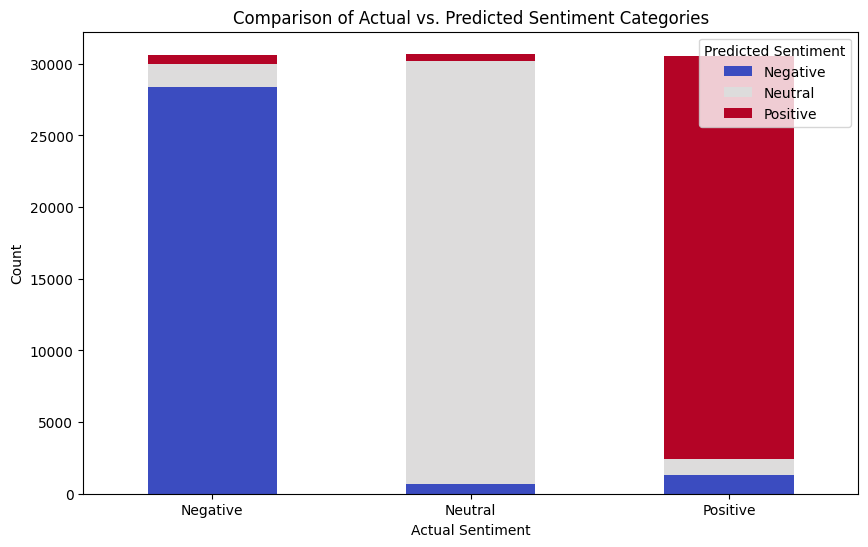

In [55]:
# Convert NumPy array to Pandas Series and align indices
y_pred_series = pd.Series(y_pred_best_logistic, index=y_val.index)

# Ensure indices are unique to avoid reindexing issues
y_val_unique = y_val.reset_index(drop=True)
y_pred_series_unique = y_pred_series.reset_index(drop=True)

# Create a DataFrame to store actual and predicted sentiment categories
comparison_df = pd.DataFrame({
    "Actual_Sentiment": y_val_unique.map(sentiment_map_reverse),
    "Predicted_Sentiment": y_pred_series_unique.map(sentiment_map_reverse)
})

# Create a confusion matrix-like count table
sentiment_comparison = comparison_df.groupby(["Actual_Sentiment", "Predicted_Sentiment"]).size().unstack()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sentiment_comparison.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(10,6))

# Labels and title
plt.title("Comparison of Actual vs. Predicted Sentiment Categories")
plt.xlabel("Actual Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)

# Show the plot
plt.legend(title="Predicted Sentiment")
plt.show()

Since the accuracy of the fine-tuned Logistic Regression is 0.93, which is high enough regarding model performance, all sentiment categoires can almost be correctly classified 🥳!

### 5️⃣ **Limitation & Insights**

### Limitation

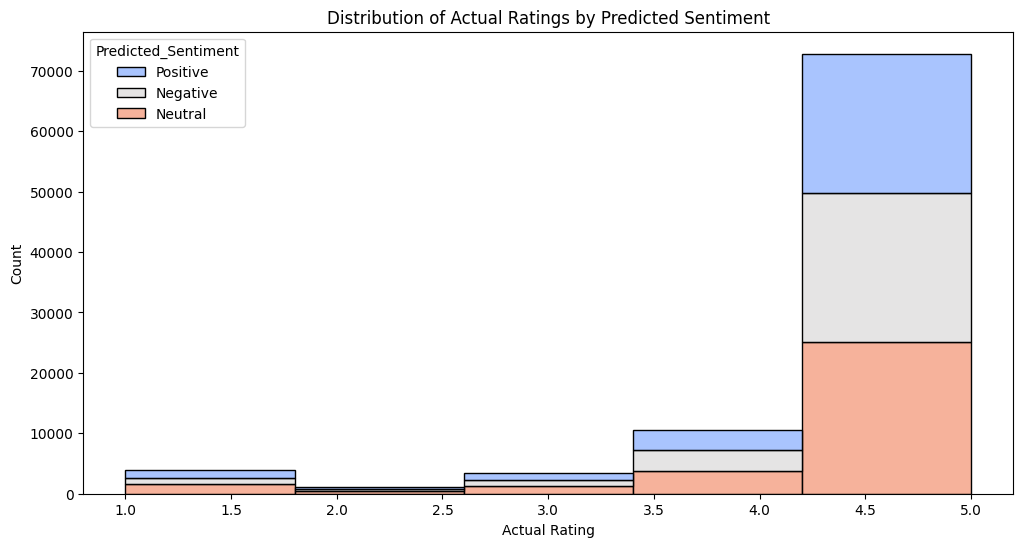

In [56]:
# Create a DataFrame to store actual ratings (from original dataset) and predicted sentiment
comparison_df = pd.DataFrame({
    "Actual_Rating": df_balanced.iloc[y_val.index]["Ratings"].values,  # Retrieve original ratings
    "Predicted_Sentiment": y_pred_best_logistic  # Predictions from fine-tuned model
})

# Map numerical sentiment predictions back to categories
sentiment_map_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}
comparison_df["Predicted_Sentiment"] = comparison_df["Predicted_Sentiment"].map(sentiment_map_reverse)

# Plot the distribution of actual ratings for each predicted sentiment category
plt.figure(figsize=(12, 6))
sns.histplot(data=comparison_df, x="Actual_Rating", hue="Predicted_Sentiment", bins=5, palette="coolwarm", multiple="stack")

# Labels and title
plt.title("Distribution of Actual Ratings by Predicted Sentiment")
plt.xlabel("Actual Rating")
plt.ylabel("Count")

# Show the plot
plt.show()

**The distribution plot suggests that while the sentiment classification model achieves high accuracy (0.93), it bold textdoes not fully align with actual user ratings**.

This discrepancy is likely due to the method used to **convert ratings into sentiment labels**. Instead of directly assigning higher ratings (4-5) as positive and lower ratings (1-2) as negative, the classification relies on a sentiment score-based approach using the compound polarity score from the analyzer.polarity_scores() function. This method classifies sentiment based on a threshold (0.05 for positive, -0.05 for negative), which may not always correspond directly to how users assign ratings.

One key reason for this misalignment is that **users may give high or low ratings based on factors beyond textual sentiment**. For example, a user could write a neutral or slightly negative review but still give a high rating (4-5) due to other factors like brand loyalty or minor inconveniences. Similarly, a user may express positive sentiment in text but give a low rating (1-2) due to a single major issue, such as a software bug or pricing concern. The sentiment classification model only interprets text sentiment and does not factor in external influences on user ratings.

Another contributing factor is that **sentiment scores focus on polarity but may not capture nuanced expressions** like sarcasm, mixed emotions, or indirect dissatisfaction. The compound score approach averages sentiment across a review, which can lead to misclassifications when a user expresses both positive and negative aspects in a single review. This explains why the model's predictions do not perfectly match the distribution of actual ratings, especially in cases where neutral sentiment is prevalent across different rating levels.

### Insights

Despite this limitation, the sentiment classification model is still highly useful for **understanding user sentiment** at scale. Even if it does not precisely predict numerical ratings, it provides a reliable measure of general sentiment trends. This can be valuable for **analyzing customer feedback, detecting dissatisfaction, identifying trends over time, and improving customer experience**. Instead of using it to predict exact ratings, businesses can leverage it to **understand sentiment shifts, prioritize areas for improvement, and enhance product development based on textual feedback**.

In conclusion, while the sentiment classification model does not fully align with actual ratings due to the nature of sentiment scoring and external rating factors, it remains a powerful tool for **extracting valuable insights from user feedback**. If more accurate rating predictions are required, a hybrid approach integrating sentiment analysis with additional structured features (e.g., length of review, specific keywords, user engagement data) could improve alignment with actual user ratings.